# ACCESS Cloud processing - GUNW Product Coverage

by: Marin Govorcin

In [1]:
%matplotlib inline
import requests
import pandas as pd
import geopandas as gpd
import folium 
import branca.colormap as cm
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import pickle

from rasterio.crs import CRS
from shapely.geometry import Polygon

In [101]:
### This part is same as in Charlie's notebook
def get_cmr_products(max_requests=None):
    session = requests.Session()
    cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
    search_params = {
        'provider': 'ASF',
        'collection_concept_id': 'C1595422627-ASF',
        'page_size': 2000,
    }
    headers = {}
    products = []
    
    k = 0
    while (max_requests is None) or (k < max_requests):
        response = session.get(cmr_url, params=search_params, headers=headers)
        response.raise_for_status()

        products.extend(response.json()['feed']['entry'])

        if 'CMR-Search-After' not in response.headers:
            break
        headers = {'CMR-Search-After': response.headers['CMR-Search-After']}
        k+= 1
    return products


def format_points(point_string):
    converted_to_float = [float(x) for x in point_string.split(' ')]
    points = [list(t) for t in zip(converted_to_float[1::2], converted_to_float[::2])]
    return points

def format_points_data(point_string_data):
    return format_points(point_string_data[0][0])

########################################
############ NEW FUNCTIONS #############

def cluster_polygons(geodf, distance=0.5):
    centers = [p.centroid for p in geodf.geometry]
    centers_xy = [[c.x, c.y] for c in centers]
    
    cluster = AgglomerativeClustering(n_clusters=None, 
                                      linkage='single',
                                      affinity='euclidean',
                                      distance_threshold=distance)
    cluster.fit(centers_xy)
    
    return cluster.labels_

def dataframe_count_per_proximity(gdf):
    aggregation_functions = {'geometry': 'first', 'reference':'min', 'secondary':'max','group': 'count', 'frame':'first', 'direction':'first'}
    rename_dic = {'reference':'first_epoch', 'secondary':'last_epoch', 'group':'count'}
    
    gdf_data = gdf.groupby(gdf['group']).aggregate(aggregation_functions)
    gdf_data.rename(columns = rename_dic, inplace = True)
    
    #convert dates to string
    gdf_data['first_epoch'] = [epoch.strftime('%Y%m%d') for epoch in gdf_data.first_epoch]
    gdf_data['last_epoch'] = [epoch.strftime('%Y%m%d') for epoch in gdf_data.last_epoch]
    
    # id needs to be string to connect it with gjson with key_on 
    gdf_data.reset_index()
    gdf_data['id'] = gdf_data.index.astype(str)
    
    
    #somewhow geopandas dataframe lose its geometry, and need to remove timestamp as it causes problems to folium
    gdf_new = gpd.GeoDataFrame(gdf_data, columns=['id', 'geometry', 'count', 'frame', 'first_epoch','last_epoch', 'direction'], 
                               geometry=[geom for geom in gdf_data['geometry']], crs=CRS.from_epsg(4326))
    
    return gdf_new


# Add custom basemaps to folium
basemaps = {
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = False,
        control = True
    ),
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = False,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = False,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = False,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = False,
        control = True
    )
}

In [3]:
%%time
data_local = True
max_requests = None # set None to download all
if not data_local:
    sample_data = get_cmr_products(max_requests=None)
    
    with open('data.pickle', 'wb') as f:
        pickle.dump(sample_data, f, pickle.HIGHEST_PROTOCOL)
else:
    with open('data.pickle', 'rb') as f:
        sample_data = pickle.load(f)
        
print('Downloaded number of granules: {}'.format(len(sample_data)))

Downloaded number of granules: 782650
CPU times: user 10.4 s, sys: 1.39 s, total: 11.8 s
Wall time: 13.1 s


In [178]:
%%time
#Create Dataframe
df = pd.DataFrame(sample_data)

#Add geometry feature and clean other unused ones 
geometry = df.polygons.apply(format_points_data).apply(Polygon)
df = gpd.GeoDataFrame(df, geometry=geometry, crs=CRS.from_epsg(4326))

#Extract info from title
df['reference'] = [int(f.split('-')[6].split('_')[0]) for f in df.title]
df['reference'] = pd.to_datetime(df['reference'],format='%Y%m%d')
df['secondary'] = [int(f.split('-')[6].split('_')[1]) for f in df.title]
df['secondary'] = pd.to_datetime(df['secondary'],format='%Y%m%d')
df['coverage'] = [f.split('-')[8] for f in df.title]
df['direction'] = [f.split('-')[2] for f in df.title]
df['frame'] = [int(f.split('-')[4]) for f in df.title]

df.drop(columns=['links','online_access_flag', 'day_night_flag',
                 'browse_flag', 'data_center', 'dataset_id',
                 'coordinate_system','original_format','collection_concept_id',
                 'producer_granule_id', 'polygons', 'granule_size', 'id',
                 'time_start', 'updated','time_end','orbit_calculated_spatial_domains'], axis=1, inplace=True)

CPU times: user 30.6 s, sys: 589 ms, total: 31.2 s
Wall time: 31 s


## Divide by orbit direction and get frames
find the "frame" based on the proximity of granule centroids on the same orbit track
use clustering to get the count of products and first and last epoch of that frame

In [179]:
%%time
################# ASCENDING ###################
ascending = df.loc[df['direction']=='A'].copy()
print(len(ascending))

ascending['group'] =np.nan
ascending.reset_index()
last_label = 0 
for i, frame in enumerate(ascending['frame'].unique()):
    if len(ascending.loc[ascending['frame']==frame]) > 1:
        label = cluster_polygons(ascending.loc[ascending['frame']==frame], distance=0.2)
        label += last_label
    else:
        label = last_label + 1
    ascending.loc[ascending['frame']==frame,['group']] = label
    last_label = np.max(label)
    
asc_df= dataframe_count_per_proximity(ascending)

478087
CPU times: user 1min 5s, sys: 43.9 ms, total: 1min 5s
Wall time: 1min 5s


In [180]:
%%time
################# DESCENDING ###################
descending = df.loc[df['direction']=='D'].copy()
print(len(descending))

descending['group'] =np.nan
descending.reset_index()
last_label = 0 
for i, frame in enumerate(descending['frame'].unique()):
    if len(descending.loc[descending['frame']==frame]) > 1:
        label = cluster_polygons(descending.loc[descending['frame']==frame], distance=0.2)
        label += last_label
    else:
        label = last_label + 1 
    descending.loc[descending['frame']==frame,['group']] = label
    last_label = np.max(label)
    
dsc_df= dataframe_count_per_proximity(descending)

304563
CPU times: user 36.1 s, sys: 19.9 ms, total: 36.1 s
Wall time: 36.1 s


In [182]:
%%time
################# TOTAL COUNT ###################
gunw_all = pd.concat([asc_df, dsc_df]).copy()

gunw_all['group'] =np.nan
gunw_all['group'] = cluster_polygons(gunw_all, distance=0.5)

aggregation_functions = {'geometry': 'first', 'count': 'sum'}

gunw_all = gunw_all.groupby(gunw_all['group']).aggregate(aggregation_functions)

gunw_all.reset_index()
gunw_all['id'] = gunw_all.index.astype(str)

gunw_all = gpd.GeoDataFrame(gunw_all, columns=['id', 'geometry', 'count'], 
                           geometry=[geom for geom in gunw_all['geometry']], crs=CRS.from_epsg(4326))
gunw_all.head()

CPU times: user 195 ms, sys: 8 ms, total: 203 ms
Wall time: 200 ms


id                                           geometry  count
group                                                             
0      0  POLYGON ((23.65797 40.08028, 23.81768 39.45489...   2141
1      1  POLYGON ((91.05338 26.72634, 88.56260 26.31478...    809
2      2  POLYGON ((-114.57693 36.98188, -117.39360 36.5...     88
3      3  POLYGON ((37.37637 34.41510, 40.12260 34.81845...   2769
4      4  POLYGON ((62.00950 34.73928, 64.74247 35.13869...    836

In [65]:
'''  
Other possible options to get the count per frame - do not work

%%time
ascending2 = ascending.copy()

aggregation_functions = {'geometry': 'first', 'reference':'min', 'secondary':'max','coverage': 'count', 'frame':'first', 'direction':'first'}
rename_dic = {'reference':'first_epoch', 'secondary':'last_epoch', 'coverage':'count'}

gdf_data = ascending2.groupby(['frame','coverage']).aggregate(aggregation_functions)
gdf_data.rename(columns = rename_dic, inplace = True)

'''

<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from panda

CPU times: user 2.35 s, sys: 24.1 ms, total: 2.37 s
Wall time: 2.36 s


<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
<timed exec>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


"   \n    gdf_data = gdf.groupby(gdf['group']).aggregate(aggregation_functions)\n    gdf_data.rename(columns = rename_dic, inplace = True)\n    \n    #convert dates to string\n    gdf_data['first_epoch'] = [epoch.strftime('%Y%m%d') for epoch in gdf_data.first_epoch]\n    gdf_data['last_epoch'] = [epoch.strftime('%Y%m%d') for epoch in gdf_data.last_epoch]\n"

[(0.0, 60.0), (0.0, 60.0)]

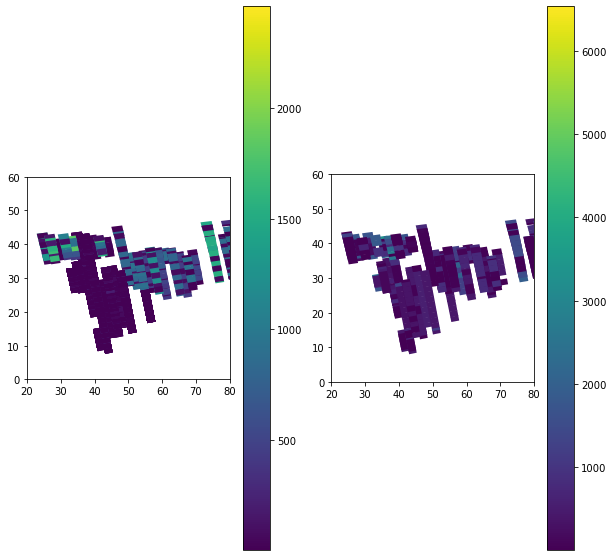

In [172]:
#Check how looks
fig, ax = plt.subplots(1,2, figsize=(10, 10))
im1 = gdf_data.plot(column='count',ax=ax[0],legend=True)
im2 = asc_df.plot(column='count',ax=ax[1],legend=True)
#im3 = ascending.plot(column='group',ax=ax[2],legend=True)
[ax[x].set_xlim([20,80]) for x in range(len(ax))]
[ax[x].set_ylim([0,60]) for x in range(len(ax))]


## Get the count per frame

In [173]:
'''
%%time
# Create new dataframes ready for foilium
gunw_all = dataframe_count_per_proximity(gunw_all)
asc_df= dataframe_count_per_proximity(ascending)
dsc_df= dataframe_count_per_proximity(descending)

gunw_all.head()
'''

'\n%%time\n# Create new dataframes ready for foilium\ngunw_all = dataframe_count_per_proximity(gunw_all)\nasc_df= dataframe_count_per_proximity(ascending)\ndsc_df= dataframe_count_per_proximity(descending)\n\ngunw_all.head()\n'

## Make folium map

In [189]:
%%time
map = folium.Map(location = [0,0], tiles=None, zoom_start = 2)

# Add hover functionality.
gstyle_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0, 
                            'weight': 0}
style_function = lambda x: {'fillColor': '#ffffff', 
                            'color':'#000000', 
                            'fillOpacity': 0.3, 
                            'weight': 0.1}
highlight_function = lambda x: {'fillColor': '#000000', 
                                'color':'#000000', 
                                'fillOpacity': 0.3, 
                                'weight': 0.1}

# Total GUNW count
gunw_total = folium.Choropleth(geo_data=gunw_all.centroid.buffer(1),
                  data=gunw_all,
                  columns=['id','count'],
                  key_on="feature.id",
                  fill_color='YlGnBu',
                  fill_opacity=1,
                  line_opacity=0.2,
                  legend_name="Total GUNW Count",
                  smooth_factor=0.7,
                  Highlight= True,
                  line_color = "#0000",
                  name = "GUNW Total Count",
                  show=True,
                  overlay=True).add_to(map)


# popup window
gunw_highlight = folium.features.GeoJson(name="Frames",
                                data=gunw_all, 
                                style_function=gstyle_function,
                                highlight_function=highlight_function,
                                show=True,
                                tooltip=folium.features.GeoJsonTooltip(
                                        fields=['count'],
                                        aliases=['Count:'],
                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    ))

gunw_total.geojson.add_child(gunw_highlight) # add it to the layer

####################################################################

#ascending
asc_count = folium.Choropleth(
    geo_data=asc_df,
    data=asc_df,
    name="Asc. track Count",
    fill_color="Reds",
    key_on="feature.id",
    columns=['id','count'],
    fill_opacity=0.6,
    line_opacity=0.4,
    show=False,
    highlight=True,
    legend_name="Ascending track -Count"
)
# popup window
asc_highlight = folium.features.GeoJson(name="Ascending Frames",
                                data=asc_df, 
                                style_function=style_function,
                                highlight_function=highlight_function, 
                                show=True,
                                tooltip=folium.features.GeoJsonTooltip(
                                        fields=['count', 'frame', 'first_epoch', 'last_epoch'],
                                        aliases=['Asc. Count:', 'Track:', 'First epoch:', 'Last epoch:'],
                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    ))

asc_count.geojson.add_child(asc_highlight) # add it to the layer
#fg_1= folium.FeatureGroup(name='count').add_to(map)
#gunw_total.geojson.add_to(fg_1)
###################################################################

#descending
dsc_count = folium.Choropleth(
    geo_data=dsc_df,
    data=dsc_df,
    name="Desc. track Count",
    fill_color="Blues",
    key_on="feature.id",
    columns=['id','count'],
    fill_opacity=0.6,
    line_opacity=0.4,
    reset=False,
    show=False,
    highlight=True,
    legend_name="Descending track - Count"
)


# popup window
dsc_highlight = folium.features.GeoJson(name="Descending Frames",
                                data=dsc_df, 
                                style_function=style_function,
                                highlight_function=highlight_function,
                                show=True,
                                tooltip=folium.features.GeoJsonTooltip(
                                        fields=['count', 'frame', 'first_epoch', 'last_epoch'],
                                        aliases=['Dsc. Count:', 'Track:', 'First epoch:', 'Last epoch:'],
                                style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    ))

dsc_count.geojson.add_child(dsc_highlight) # add it to the layer



#Charlie heat map
heat_map = False
if heat_map:
    import folium.plugins
    folium.plugins.HeatMap([[point.centroid.xy[1][0], point.centroid.xy[0][0]] for point in df.geometry ],
                    #gradient=gradient_map,
                    name='heat map',
                    blur=5,
                    radius=10).add_to(map)


#Basemaps
[basemaps[basemap].add_to(map) for basemap in basemaps]
folium.TileLayer('cartodbdark_matter',name="dark mode",control=True).add_to(map)
folium.TileLayer('cartodbpositron',name="light mode",control=True).add_to(map)


asc_count.add_to(map)
dsc_count.add_to(map)

folium.LayerControl().add_to(map)
display(map)

'''
colormap_1= cm.linear.YlGnBu_06.scale(0,180)
colormap_1= colormap_1.to_step(index=[0,30,60,90,120,150,180])
colormap_1.caption= 'count'
colormap_1.add_to(map)
map
'''

<timed exec>:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

<timed exec>:18: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



CPU times: user 4.62 s, sys: 7.97 ms, total: 4.63 s
Wall time: 4.62 s


"\ncolormap_1= cm.linear.YlGnBu_06.scale(0,180)\ncolormap_1= colormap_1.to_step(index=[0,30,60,90,120,150,180])\ncolormap_1.caption= 'count'\ncolormap_1.add_to(map)\nmap\n"

In [186]:
map.save("GUNW_coverage.html")